In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pylab as plt

from makeCorner import *

az.rcParams["plot.max_subplots"] = 80

In [2]:
cdf_file = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Redshift_in_Mass_sigmoid/cdf_files_sigmoid//CBC_O3_smaller_priors_on_middle_m_30_75.cdf"
# "./RUNS/CBC_O3_Reverse_Sector.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

In [3]:
def sigmoid_zp(low, high, width, middle, mass):
    return (high - low) / (1 + jnp.exp(-(1/width)*(mass - middle))) + low

def sigmoid_delta(low, delta, width, middle, mass):
    return (delta) / (1 + jnp.exp(-(1/width)*(mass - middle))) + low

def merger_rate_zp_sigmoid(alpha_z,delta_alpha, width_alpha_z, middle_alpha_z,
                           beta_z, high_beta_z, width_beta_z, middle_beta_z,
                           low_zp, high_zp, width_m, m_middle, masses, z_s):
    alpha_z = sigmoid_delta(alpha_z, delta_alpha, width_alpha_z, middle_alpha_z, masses)
    beta_z = sigmoid_zp(beta_z, high_beta_z, width_beta_z, middle_beta_z, masses)
    new_zp = sigmoid_zp(low_zp, high_zp, width_m, m_middle, masses)
    return (1+z_s)**alpha_z/(1+((1+z_s)/(1+new_zp))**(alpha_z+beta_z))

m_grid = np.linspace(2,120,500)

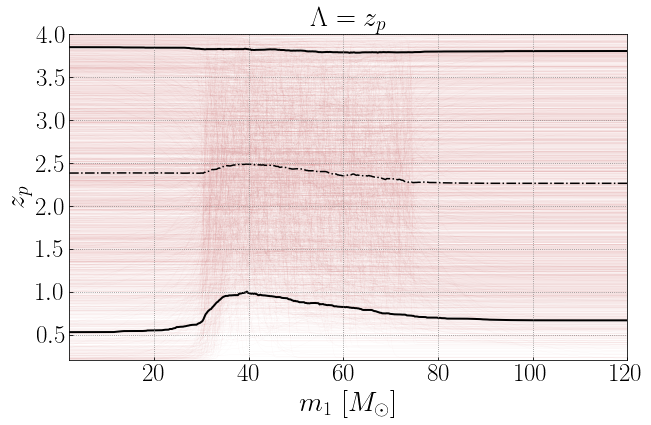

In [6]:
fig,ax = plt.subplots(figsize=(10,6))
ax.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))
for i in range(samps.alpha_ref.size):
    zp = sigmoid_zp(samps.low_zp.values[i], samps.high_zp.values[i], 10.**samps.log_width_zp.values[i], samps.middle_m.values[i], m_grid)
    ax.plot(m_grid, zp, color='#e31a1c', lw=0.1, alpha = 0.1, zorder = 1)
    zp_matrix[i, :] = zp
    
median_zp = np.median(zp_matrix, axis = 0)
    
ax.set_xlim(2,120)
ax.set_ylim(0.2,4)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 28)
ax.set_ylabel(r"$z_p$", fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.plot(m_grid, median_zp, "-.", c="k", zorder = 1)
ax.plot(m_grid,np.quantile(zp_matrix,0.05,axis=0), zorder = 1, color='k', lw=2, alpha=1)
ax.plot(m_grid,np.quantile(zp_matrix,0.95,axis=0), zorder = 1, color='k', lw=2, alpha=1)
plt.title(r"$\Lambda = z_p$", fontsize = 28)
plt.savefig("Trace_zp_reverse.pdf", dpi = 400, bbox_inches = "tight")
plt.show()

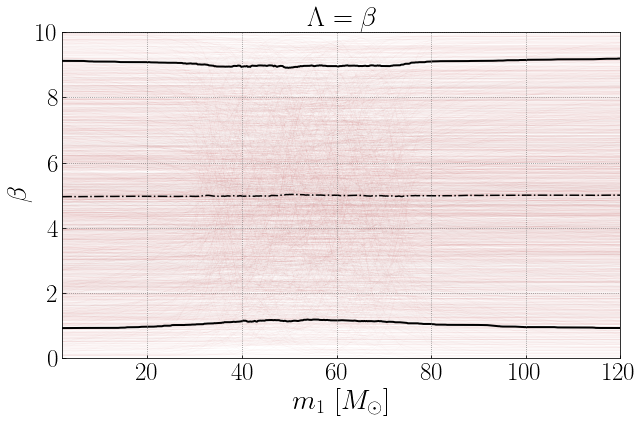

In [9]:
fig,ax = plt.subplots(figsize=(10,6))
ax.set_rasterization_zorder(2)
beta_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))
for i in range(samps.alpha_ref.size):
    zp = sigmoid_zp(samps.beta_z.values[i], samps.high_beta_z.values[i], 10.**samps.width_beta_z.values[i], samps.middle_m_beta_z.values[i], m_grid)
    ax.plot(m_grid, zp, color='#e31a1c', lw=0.1, alpha = 0.1, zorder = 1)
    beta_matrix[i, :] = zp
    
median_beta = np.median(beta_matrix, axis = 0)

ax.set_xlim(2,120)
ax.set_ylim(0,10)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 28)
ax.set_ylabel(r"$\beta$", fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.plot(m_grid, median_beta, "-.", c="k", zorder = 1)
ax.plot(m_grid,np.quantile(beta_matrix,0.05,axis=0), zorder = 1, color='k', lw=2, alpha=1)
ax.plot(m_grid,np.quantile(beta_matrix,0.95,axis=0), zorder = 1, color='k', lw=2, alpha=1)
plt.title(r"$\Lambda = \beta$", fontsize = 28)
plt.savefig("Trace_beta_reverse.pdf", dpi = 400, bbox_inches = "tight")
plt.show()

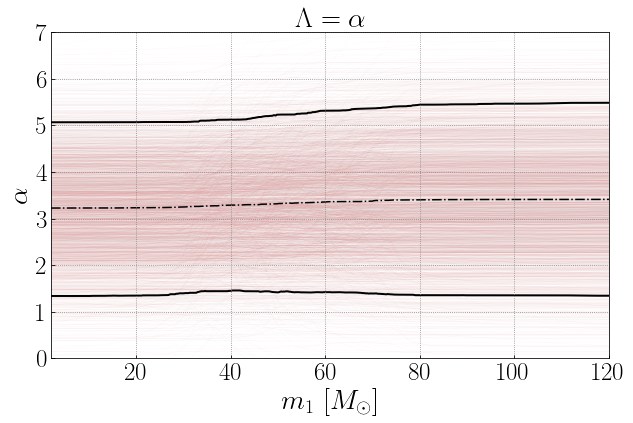

In [10]:
fig,ax = plt.subplots(figsize=(10,6))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))
for i in range(samps.alpha_ref.size):
    zp = sigmoid_delta(samps.alpha_z.values[i], samps.delta_alpha_z.values[i], 10.**samps.width_alpha_z.values[i], samps.middle_m_alpha_z.values[i], m_grid)
    ax.plot(m_grid, zp, color='#e31a1c', lw=0.1, alpha = 0.1, zorder = 1)
    alpha_matrix[i, :] = zp
    
median_alpha = np.median(alpha_matrix, axis = 0)
ax.set_xlim(2,120)
ax.set_ylim(0,7)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 28)
ax.set_ylabel(r"$\alpha$", fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.plot(m_grid, median_alpha, "-.", c="k", zorder = 1)
ax.plot(m_grid,np.quantile(alpha_matrix,0.05,axis=0), zorder = 1, color='k', lw=2, alpha=1)
ax.plot(m_grid,np.quantile(alpha_matrix,0.95,axis=0), zorder = 1, color='k', lw=2, alpha=1)
plt.title(r"$\Lambda = \alpha$", fontsize = 28)
plt.savefig("Trace_alpha_reverse.pdf", dpi = 400, bbox_inches = "tight")
plt.show()